In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

We predefine some functions in order to preprocess images.

In [ ]:
def image_resize(img):
  ''' 
  Function for image resize (accelerate computations)
  '''
  h, w, layers = img.shape
  new_h = 540
  new_w = 860
  res_img = cv2.resize(img, (new_w, new_h))
  return res_img

def image_transform(img):
  '''
  Function to make image's perspective transformation 
  '''
  pts1 = np.float32([[180,50], [700,50], [0, 500], [860, 500]])
  pts2 = np.float32([[0, 0], [860, 0], [0, 540], [860, 540]])
  M = cv2.getPerspectiveTransform(pts1, pts2)
  dst = cv2.warpPerspective(img, M, (860, 540))
  return dst

def image_cropper(img):
  '''
  Function to cut off the unneeded parts (Windows bars) from image
  '''
  img = img[30:1030,:,:]
  return img

For dataset the screenshots from Pro Evolution Soccer 2016 videogame were taken.

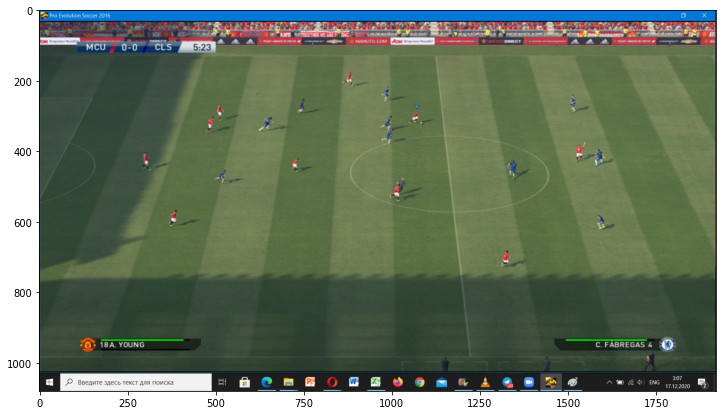

In [ ]:
image_test = cv2.imread("/content/drive/MyDrive/Intro to CV/project/img_8.png")
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_original = np.copy(image_test)
plt.figure(figsize = (15,7))
plt.imshow(image_test)

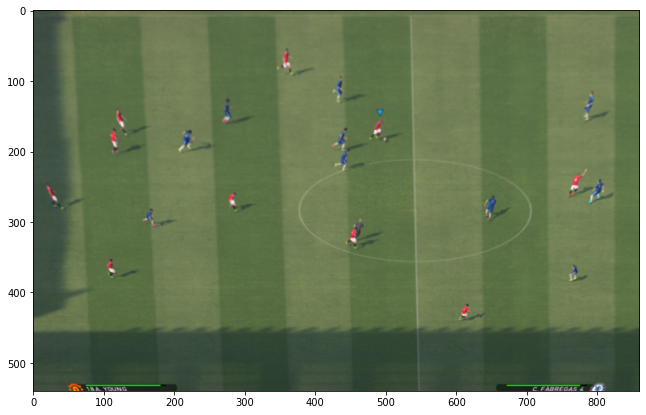

In [ ]:
# applying functions in order to prepare image
# cropping
image_test = image_cropper(image_test)
image_try = np.copy(image_test)

# resizing
image_test = image_resize(image_test)

# transforming
image_test = image_transform(image_test)

plt.figure(figsize = (15,7))
plt.imshow(image_test)

It can be seen that we obtained good result with projective transformation of footbal field with players. Now it looks almost like a bird's eye view. \
However, some territory is lost because of the transformation. This can lead to the False Negative results when tracking the footballer.

Next we want to try to predefine boundaries for colours of each team players t-shirts.

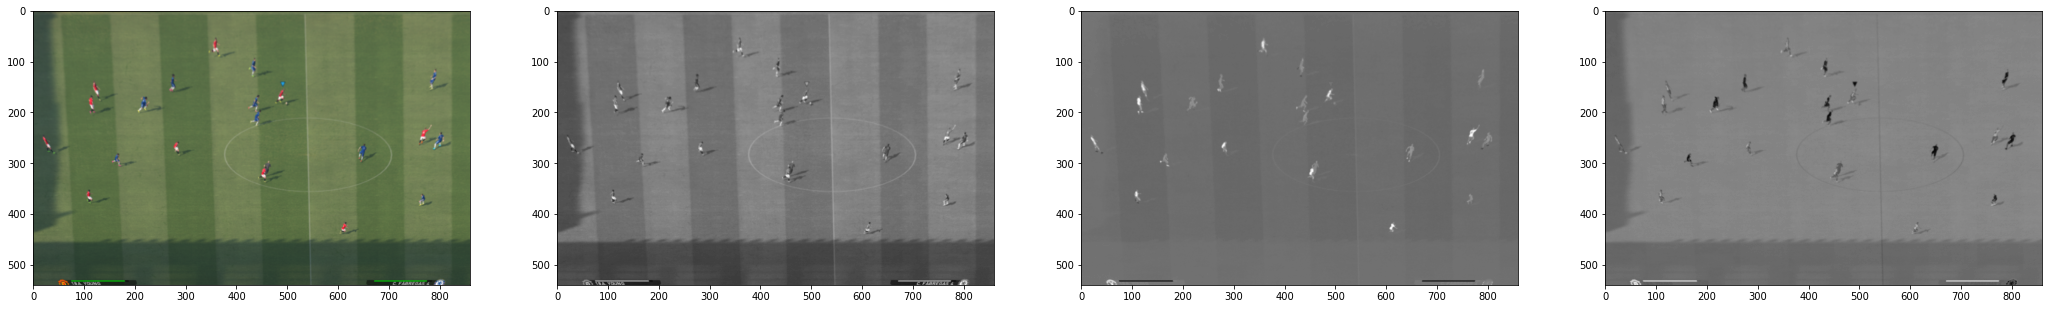

In [ ]:
# players segmentation

image_tr = np.copy(image_test)
image_tr_lab = cv2.cvtColor(image_tr, cv2.COLOR_RGB2LAB)
L = image_tr_lab[:,:,0]
A = image_tr_lab[:,:,1]
B = image_tr_lab[:,:,2]
image_tr_gray = cv2.cvtColor(image_tr, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (36,6))
plt.subplot(1,4,1)
plt.imshow(image_tr)
plt.subplot(1,4,2)
plt.imshow(L, cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(A, cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(B, cmap = 'gray')

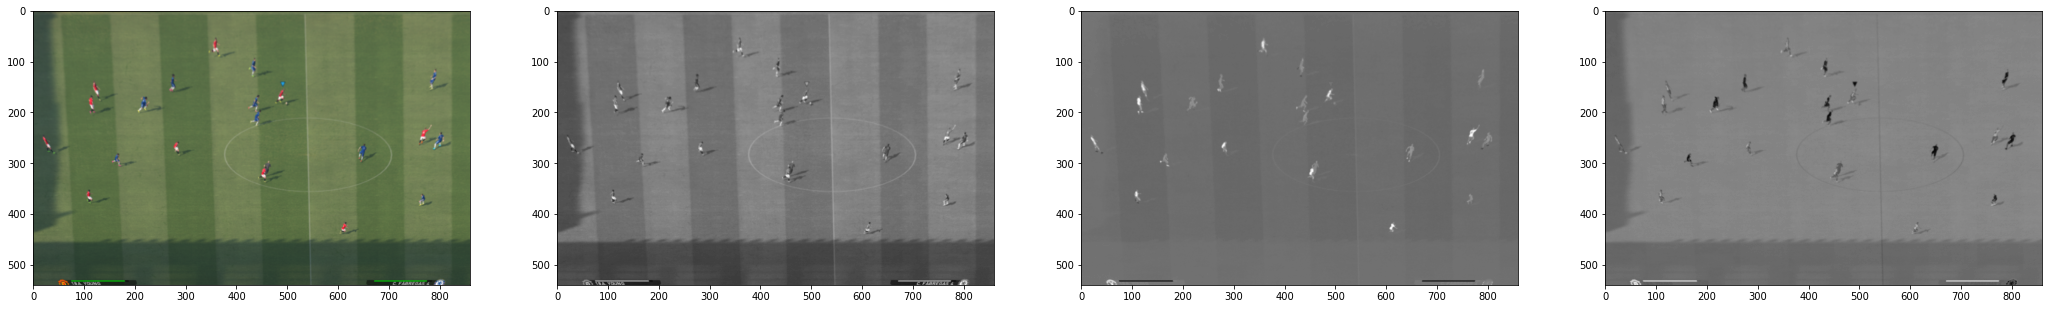

In [ ]:
image_tr = np.copy(image_test)
image_tr_hsv = cv2.cvtColor(image_tr, cv2.COLOR_RGB2LAB)
H = image_tr_hsv[:,:,0]
S = image_tr_hsv[:,:,1]
V = image_tr_hsv[:,:,2]
image_tr_gray = cv2.cvtColor(image_tr, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (36,6))
plt.subplot(1,4,1)
plt.imshow(image_tr)
plt.subplot(1,4,2)
plt.imshow(H, cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(S, cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(V, cmap = 'gray')

In [ ]:
image_try_lab = cv2.cvtColor(image_try, cv2.COLOR_RGB2LAB)

L_try = image_try_lab[:,:,0]
A_try = image_try_lab[:,:,1]
B_try = image_try_lab[:,:,2]

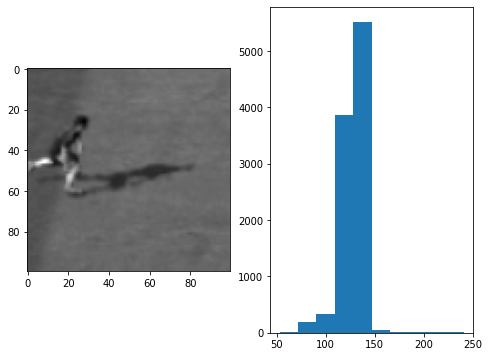

In [ ]:
# color search playground 
img_playground = L_try[400:500, 500:600]
plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
plt.imshow(img_playground, cmap = 'gray')
plt.subplot(1,2,2)
plt.hist(img_playground.flatten());

Text(0.5, 0, 'Red players')

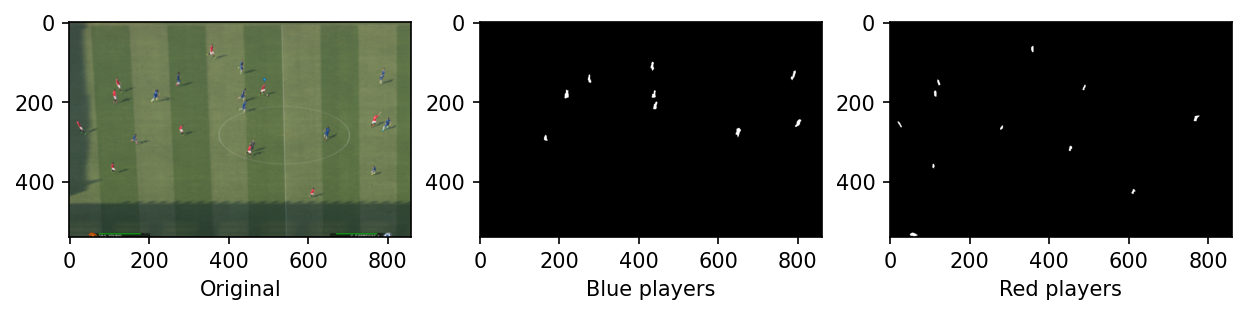

In [ ]:
red_players_mask = (A > 150)
red_players_mask = remove_small_objects(red_players_mask, min_size = 25)
red_players_mask = red_players_mask.astype(np.uint8)
kernel = np.ones((5,5))
red_players_mask = cv2.morphologyEx(red_players_mask, cv2.MORPH_CLOSE, kernel)

blue_players_mask = (B < 125)
blue_players_mask = remove_small_objects(blue_players_mask, min_size = 70)
blue_players_mask = blue_players_mask.astype(np.uint8)
kernel = np.ones((7,7))
blue_players_mask = cv2.morphologyEx(blue_players_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(dpi=150, figsize=(10, 6))
plt.subplot(1,3,1)   
plt.imshow(image_tr)
plt.xlabel('Original')
plt.subplot(1,3,2)     
plt.imshow(blue_players_mask, cmap='gray')
plt.xlabel('Blue players')
plt.subplot(1,3,3)     
plt.imshow(red_players_mask, cmap='gray')
plt.xlabel('Red players')

Below is a bad example of our try to have a separate segmentation of the fooball field.

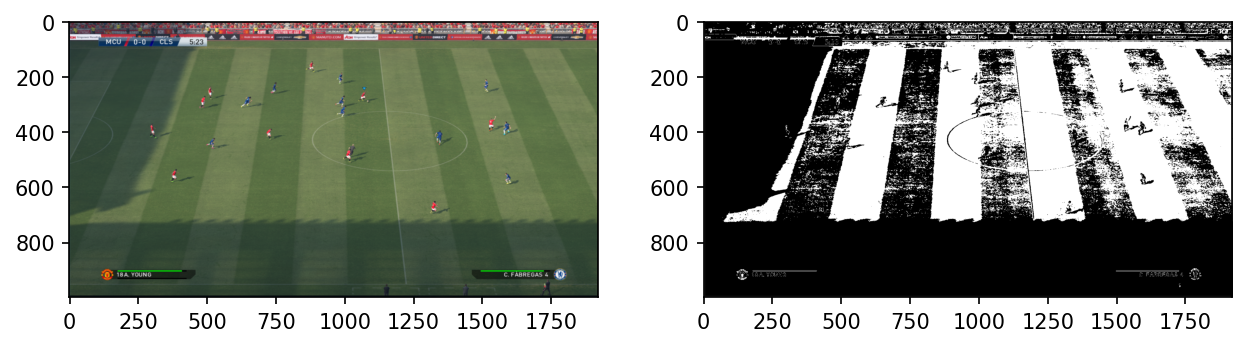

In [ ]:
# try to define pitch through colour segmentation
field_mask = (L_try > 115) & (L_try < 150)

#field_mask = remove_small_objects(field_mask, min_size = 2500)
field_mask = np.uint8(field_mask)
#kernel = np.ones((17,17))
#field_mask = cv2.morphologyEx(field_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(dpi=150, figsize=(10, 6))
plt.subplot(1,2,1)   
plt.imshow(image_try)
plt.subplot(1,2,2)     
plt.imshow(field_mask, cmap='gray')

This is our failure to define pitch through contours. \
It can be seen that if it works with one picture, it is not guranteed to work with others because shadows, different colours, small details, etc.

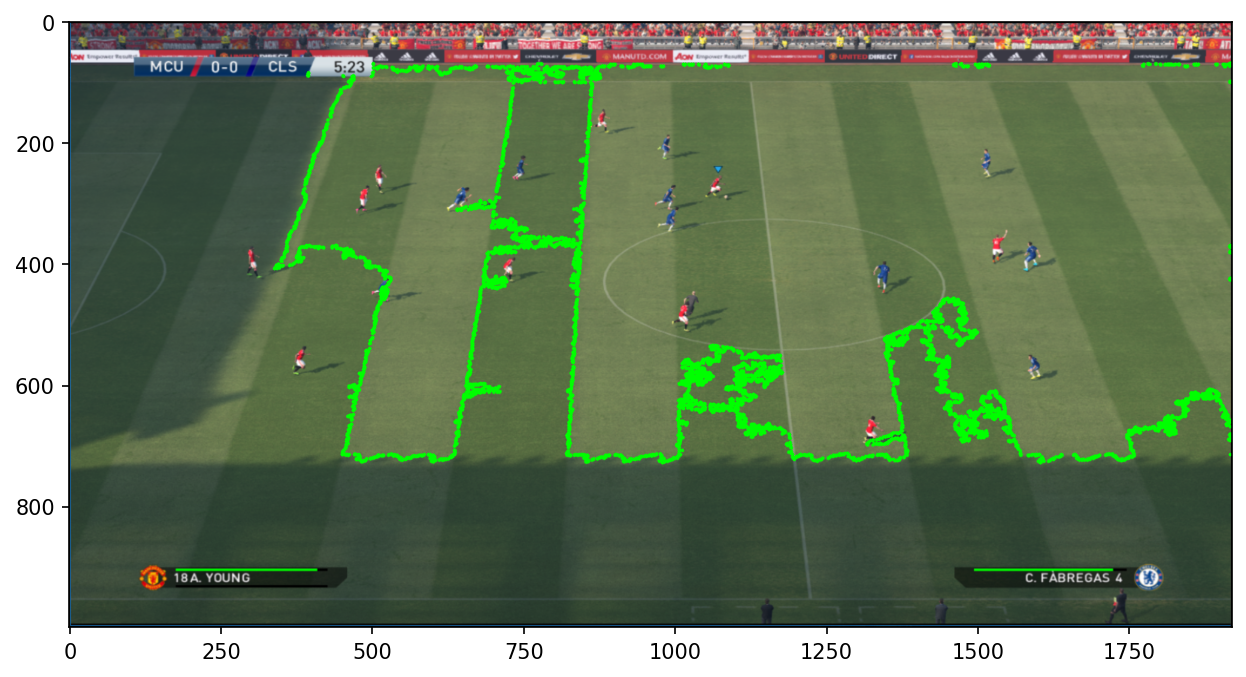

In [ ]:
# we can try to define football field contour in order to proceed with it
img_cnt = np.copy(image_try)

cnts = cv2.findContours(field_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

c = max(cnts, key = cv2.contourArea)

cv2.drawContours(img_cnt, c, -1, (0,255,0), 5)

plt.figure(dpi=150, figsize=(10, 6))
plt.imshow(img_cnt)

We decided to have a desk in the form of contours of football field's lines. For this we are going to obtain them through colour schemes (LAB).

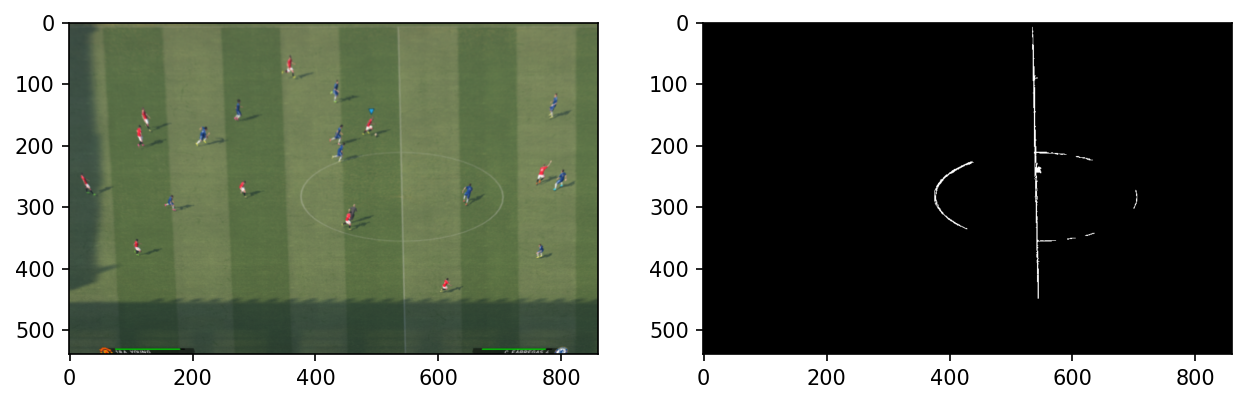

In [ ]:
field_mask = (L > 142) & (L < 160)

field_mask = remove_small_objects(field_mask, min_size = 20)
field_mask = np.uint8(field_mask)

plt.figure(dpi=150, figsize=(10, 6))
plt.subplot(1,2,1)   
plt.imshow(image_tr)
plt.subplot(1,2,2)     
plt.imshow(field_mask, cmap='gray')

It is needed to convert this lines into the 3-dim picture for future purposes of usage.

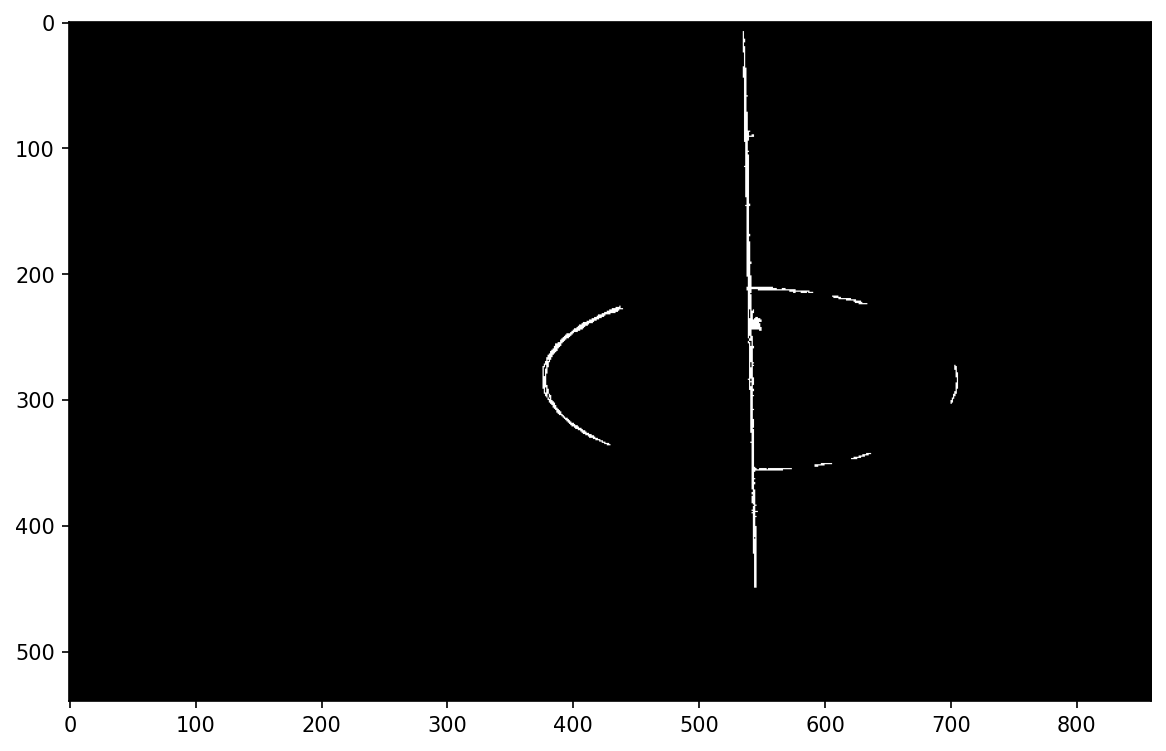

In [ ]:
# convert to 3 channel images
field_mask_3 = np.zeros_like(image_tr)
field_mask_3[:,:,0] = 255*field_mask
field_mask_3[:,:,1] = 255*field_mask
field_mask_3[:,:,2] = 255*field_mask

plt.figure(dpi=150, figsize=(10, 6)) 
plt.imshow(field_mask_3)

Now we can try to create a desk of football coach! Let's start from the defining each team's players.

Number of countours here:  11


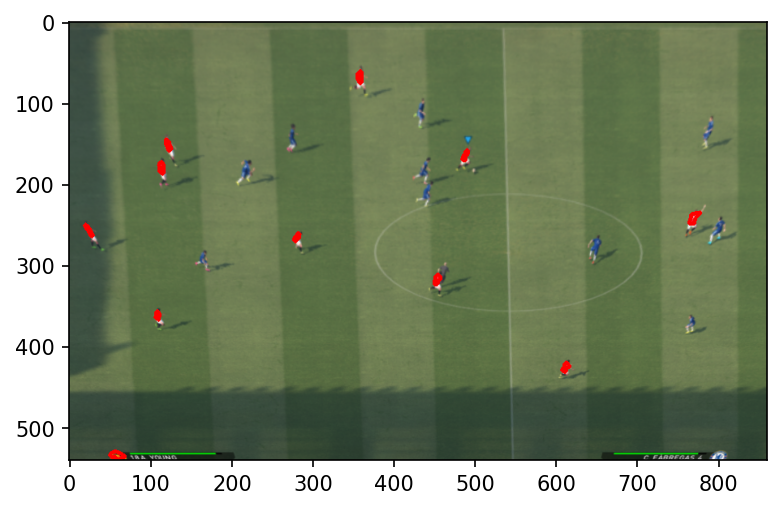

In [ ]:
# we look for each team's players separately
contours_red, hierarchy = cv2.findContours(red_players_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_cnt = image_tr.copy()
cv2.drawContours(img_cnt, contours_red, -1, (255,0,0), 3)
plt.figure(dpi=150)
plt.imshow(img_cnt)

print("Number of countours here: ", str(len(contours_red)))

Number of countours here:  9


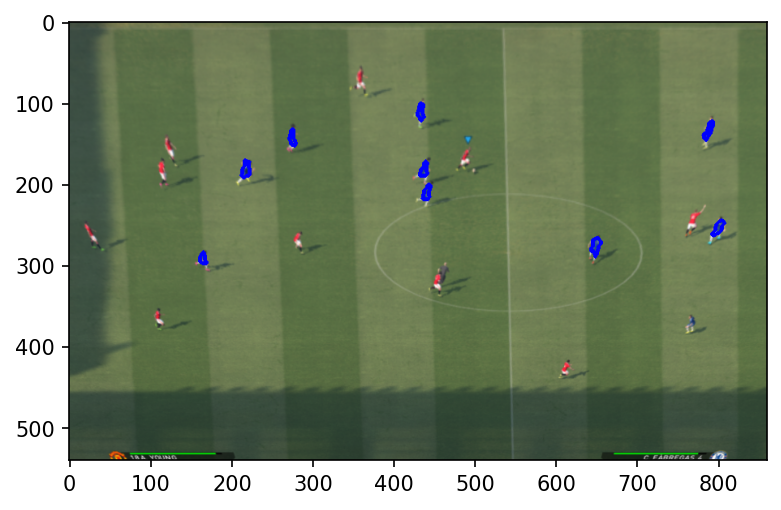

In [ ]:
contours_blue, hierarchy = cv2.findContours(blue_players_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_cnt = image_tr.copy()
cv2.drawContours(img_cnt, contours_blue, -1, (0,0,255), 3)
plt.figure(dpi=150)
plt.imshow(img_cnt)

print("Number of countours here: ", str(len(contours_blue)))

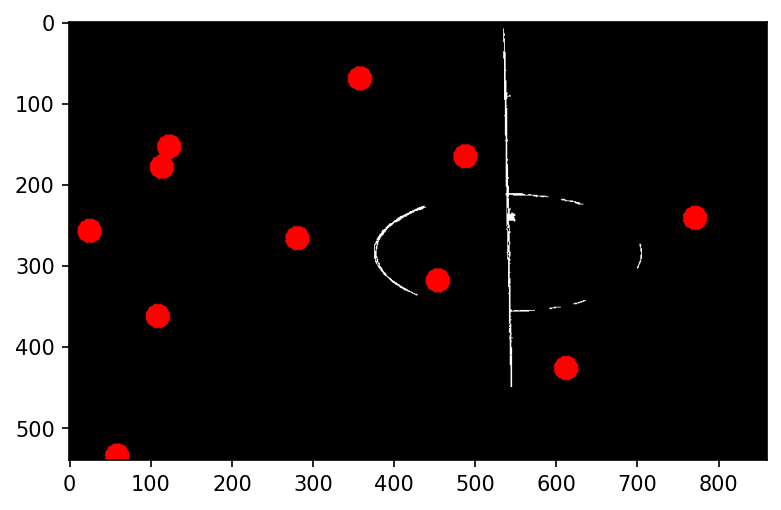

In [ ]:
# centers of mass for red players

img_mass = field_mask_3.copy()

train_mass = np.zeros([len(contours_red), 2])

for i in range(len(contours_red)):
  
  kpCnt = len(contours_red[i])
  x = 0
  y = 0

  for kp in contours_red[i]:
    x = x+kp[0][0]
    y = y+kp[0][1]

  train_mass[i][0] = np.uint32(np.ceil(x/kpCnt))
  train_mass[i][1] = np.uint32(np.ceil(y/kpCnt))

  cv2.circle(img_mass, (np.uint32(np.ceil(x/kpCnt)), np.uint32(np.ceil(y/kpCnt))), 5, (255, 0, 0), 20)

plt.figure(dpi = 150)
plt.imshow(img_mass)

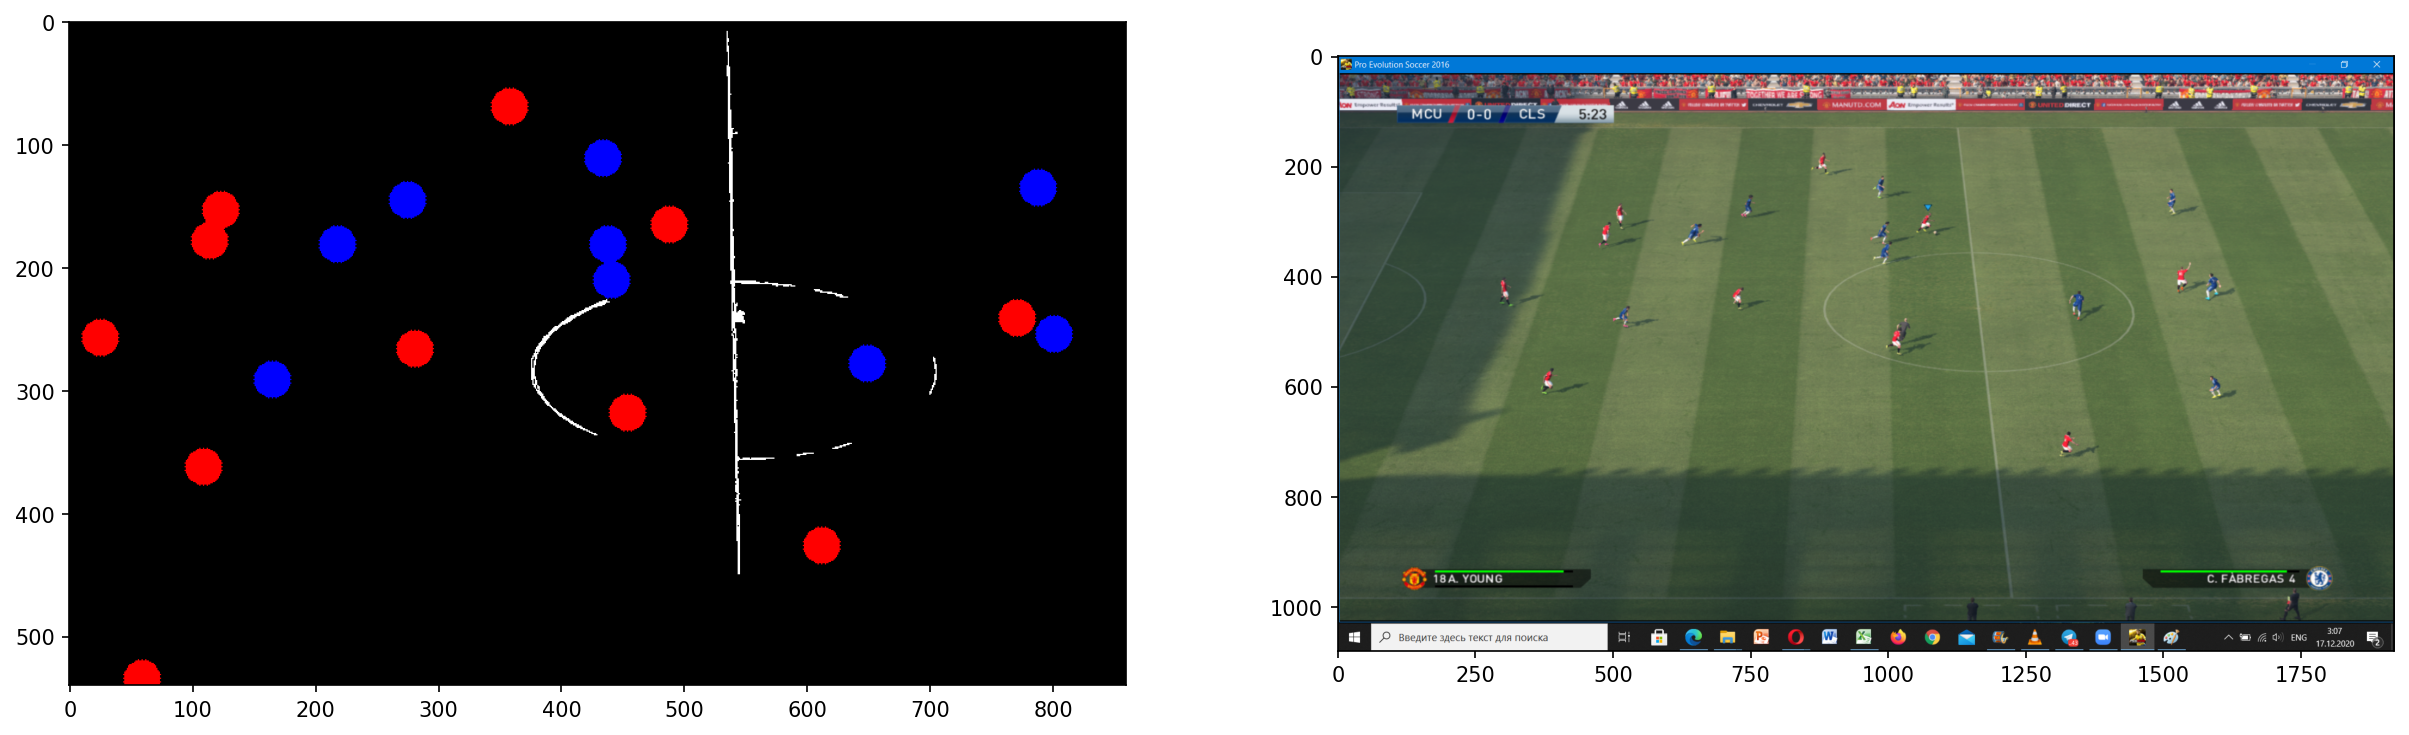

In [ ]:
# centers of mass for blue players

#img_mass = field_mask_3.copy()

train_mass = np.zeros([len(contours_blue), 2])

for i in range(len(contours_blue)):
  
  kpCnt = len(contours_blue[i])
  x = 0
  y = 0

  for kp in contours_blue[i]:
    x = x+kp[0][0]
    y = y+kp[0][1]

  train_mass[i][0] = np.uint32(np.ceil(x/kpCnt))
  train_mass[i][1] = np.uint32(np.ceil(y/kpCnt))

  cv2.circle(img_mass, (np.uint32(np.ceil(x/kpCnt)), np.uint32(np.ceil(y/kpCnt))), 5, (0, 0, 255), 20)

plt.figure(dpi = 150, figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_mass)
plt.subplot(1,2,2)
plt.imshow(image_original)

Well, it can be seen that for different pictures we obtain different results. In average we get 84% accuracy, which is quite good. \
The biggest pains are: \
1) Man Utd logo in the left bottom side (defined as False Positive - too red) \
2) Players which are very close to the left/right side of the screenshot (can not be seen because of transformation)

## Video part

We also decided that it can be nice to monitor positions in a real-time format. However our powers are limited (in terms of computer power), so we decided to create pre-recorded video from football match ourselves and try to monitor all the players right there. \
The algorithm for this is given below.

Examples of obtained results for online players tracking are available on YouTube:\
Game record: https://youtu.be/7tNIcEiqZhM \
Tracking record: https://youtu.be/YQVNW2ro4jE 

True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read a new frame:  True
(720, 1280, 3)
Read 

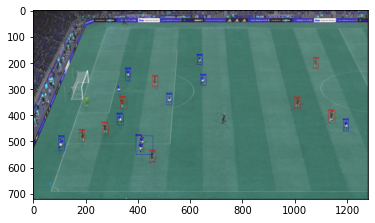

In [ ]:
# first we need to capture pre-recorded video file
vidcap = cv2.VideoCapture('/content/drive/MyDrive/Intro to CV/project/video_match_medium.mp4')
success,image = vidcap.read()

success = True

count = 0
idx = 0

#Read the video frame by frame
while success:

  # Convert BGR to HSV format
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  
  # THE COLOURS BOUNDS BELOW ARE TAKEN THROUGH LONG MANUAL SEARCH IN THE FORM OF PLAYGROUND !
  # GREEN
  lower_green = np.array([33, 82, 110])
  upper_green = np.array([40, 130, 140])
  
  # BLUE
  lower_blue = np.array([100, 20, 60])
  upper_blue = np.array([130, 130, 160])
  
  # RED
  lower_red = np.array([0,110,100])
  upper_red = np.array([20,200,220])
  
  # Mask should go from the lower bound to upper bound for the football pitch
  mask = cv2.inRange(hsv, lower_green, upper_green)
  
  # masking
  res = cv2.bitwise_and(image, image, mask=mask)
  
  # HSV 2 GRAY
  res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
  res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
  
  # kernel is for blurring (morphological)
  kernel = np.ones((3,3),np.uint8)
  thresh = cv2.threshold(res_gray, 127, 255, cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

  # finding contours of image
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # finding players on each image separately
    if (h >= w):
      if (w > 10 and h>= 10) and (w < 250 and h < 250):
        idx = idx+1
        player_img = image[y:y+h,x:x+w]
        player_hsv = cv2.cvtColor(player_img,cv2.COLOR_BGR2HSV)
        
        # If player in a blue t-shirt
        mask_blue = cv2.inRange(player_hsv, lower_blue, upper_blue)
        res_blue = cv2.bitwise_and(player_img, player_img, mask=mask_blue)
        res_blue = cv2.cvtColor(res_blue,cv2.COLOR_HSV2BGR)
        res_blue = cv2.cvtColor(res_blue,cv2.COLOR_BGR2GRAY)
        nzCount = cv2.countNonZero(res_blue)
        
        # If player in a red t-shirt
        mask2 = cv2.inRange(player_hsv, lower_red, upper_red)
        res_red = cv2.bitwise_and(player_img, player_img, mask=mask2)
        res_red = cv2.cvtColor(res_red, cv2.COLOR_HSV2BGR)
        res_red = cv2.cvtColor(res_red, cv2.COLOR_BGR2GRAY)
        nzCountred = cv2.countNonZero(res_red)
        
        if (nzCount >= 20):
          # If t-shirt is blue: Chelsea
          cv2.putText(image, 'Chelsea', (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255,0,0), 1, cv2.LINE_AA)
          cv2.rectangle(image, (x,y), (x+w,y+h), (255,0,0), 1)
        else:
          pass
        
        if (nzCountred>=20):
          # If t-shirt is red: Manchester United
          cv2.putText(image, 'ManUtd', (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0,0,255), 1, cv2.LINE_AA)
          cv2.rectangle(image, (x,y), (x+w,y+h), (0,0,255), 1)
        else:
          pass

  cv2.imwrite("/content/drive/MyDrive/Intro to CV/project/frames/frame%d.png" % count, image)
  
  print('Reading next frame: ', success) # save frame as JPEG file
  count += 1
  
  print(image.shape)
    
  success,image = vidcap.read()

vidcap.release()

Now we need to save the obtained pictures (frames) in video format

In [ ]:
import os

In [ ]:
!pip install sk-video

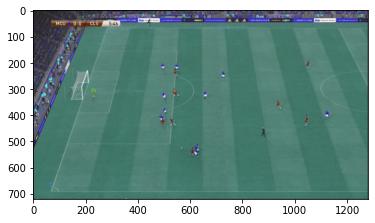

In [ ]:
ii = cv2.imread("/content/drive/MyDrive/Intro to CV/project/frames/frame366.png")
plt.imshow(ii)

For collecting the videoclip we are going to use *skvideo* library. \
It allows to do it on the fly without deep knowledge of video recording details. \
However we must highlight one important fact that by default, scikit-video assumes pix_fmt is yuvj444p, to provide consistent saving and loading of video content while also maintaining signal fidelity. Note that the current state of skvideo does not support direct loading of yuv420p. \
It means that on Windows it would not be possible to play this video with the help of Windows media player. \
Fortunatelly, the easiest way to solve it is to use VLC media player.

In [ ]:
import numpy as np
import skvideo.io

# define amount of frames in folder
n_frames = len(os.listdir("/content/drive/MyDrive/Intro to CV/project/frames/") )

# define h,w,l in each image
img=[]
for i in range(n_frames):
    img.append(cv2.imread('/content/drive/MyDrive/Intro to CV/project/frames/frame' + str(i) + '.png'))
height, width, layers = img[1].shape

# create matrix for filling with images consequently
out_video =  np.empty([n_frames, height, width, 3], dtype = np.uint8)
out_video =  out_video.astype(np.uint8)

for idx, i in enumerate(img):
  # convert BGR 2 RGB
  invert_i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
  out_video[idx] = invert_i

# Writes the the output image sequences in a video file
skvideo.io.vwrite("video2.mp4", out_video)


512
